# Geometry
This notebook is for experiments with how 3D geometry can be used to manipulate camera rays for a NeRF.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial.transform import Rotation
from glob import glob
np.set_printoptions(precision=6, suppress=True)
# %matplotlib notebook

In [4]:
c = sphere_center = np.array([1,1,1])
actual_sphere_center = np.array([1,1,1])
def make_plot(figure=None, cols=2):
    fig = figure or plt.figure(figsize=(8,8))
    #subplots = (1,2,1) if figure else (1,1,1)
    if figure:
        axes = [fig.add_subplot(1,cols,i+1, projection='3d') for i in range(cols)]
    else:
        axes = [fig.add_subplot(projection='3d')]
    
    for ax in axes:
        # draw sphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        r = 0.25
        x = actual_sphere_center[0] + r*np.cos(u)*np.sin(v)
        y = actual_sphere_center[1]+ r*np.sin(u)*np.sin(v)
        z = actual_sphere_center[2] + r*0.75*np.cos(v+0.2*u)
        # alpha controls opacity
        ax.plot_surface(x, y, z, cmap="viridis", alpha=1.0)

        ax.set_box_aspect([1,1,1])
        ax.set_xlabel('X', fontsize=16)
        ax.set_ylabel('Z', fontsize=16)
        ax.set_zlabel('Y', fontsize=16)

        margin = 1.5
        ax.set_xlim(sphere_center[0]-margin,sphere_center[0]+margin)
        ax.set_ylim(sphere_center[1]-margin,sphere_center[1]+margin)
        ax.set_zlim(sphere_center[2]-margin,sphere_center[2]+margin)
        ax.view_init(elev=40, azim=-155)
        #ax.view_init(elev=-90, azim=-90)
    return fig,axes
#make_plot()
#plt.show()

/var/folders/dd/w12rk9bs497128bhpkfq38zc0000gn/T/ipykernel_92592/136038818.py:54: UserWarning: Optimal rotation is not uniquely or poorly defined for the given sets of vectors.
  A  = np.stack(Rotation.align_vectors([[0,1,0]], rd[0:1,:])[0].as_matrix() for rd in rays_d)


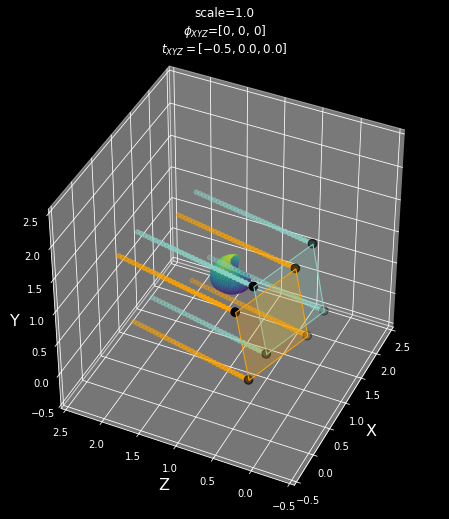

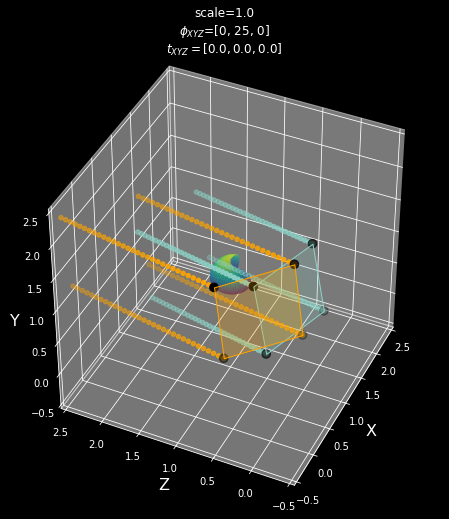

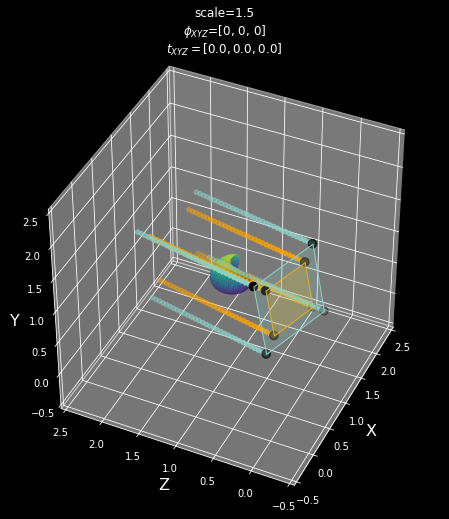

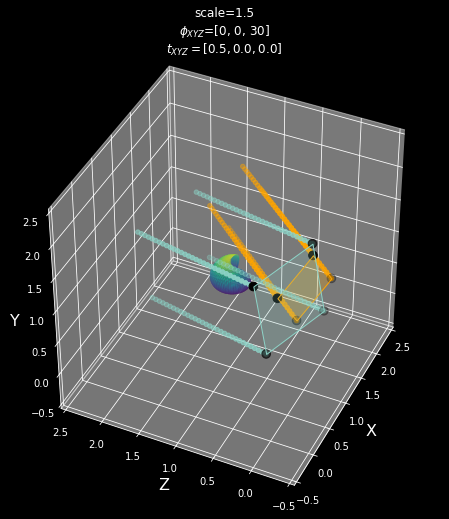

In [5]:
transformations = [
    (1.0, [0,0,0], [-0.5,0,0]),
    (1.0, [0,0,25], [0,0,0]),
    (1.5, [0,0,0], [0,0,0]),
    (1.5, [0,30,0], [0.5,0,0]),
]

for i,(s,theta,tx) in enumerate(transformations):
    o1 = np.array([
        #[-0.75,-1,-0.5],
        #[-0.75,-1,0.5],
        #[0.75,-1,0.5],
        #[0.75,-1,-0.5],
        [-0.5,-1,-0.5],
        [-0.5,-1,0.5],
        [0.5,-1,0.5],
        [0.5,-1,-0.5],
    ])
    o1 += np.array([1,1,1])

    #actual_sphere_center = np.array([0.0,0.0,0.0])
    # sphere_center = np.array([0,0,0])

    rotations = [
        Rotation.from_euler('xyz',[10,0,20], degrees=True),
    #    Rotation.from_euler('z',20+90, degrees=True),
    #    Rotation.from_euler('xyz',[10,0,20+180], degrees=True),
    #    Rotation.from_euler('z',20+90+90+90, degrees=True)
    ]

    k=1
    rays_o = np.array([
        (o1-sphere_center)@rot.as_matrix()+sphere_center
        for rot in rotations
    ])
    d1 = np.tile([0,1,0], (4,1))
    rays_d = np.array([
        d1@rot.as_matrix()
        for rot in rotations
    ])
    z = np.linspace(0,2,32)[None,:]
    points = rays_o[...,None] + z*rays_d[...,None]
    t = np.array(tx)
    S = np.array([
        [1/s,0,0],
        [0,1,0],
        [0,0,1/s]
    ])
    R = Rotation.from_euler('xyz', theta, degrees=True).as_matrix()

    #reconst
    #r = R.align_vectors(np.tile([[0,1,0]], reps=(len(rotations),1)), rays_d[:,0,:])[0].as_matrix()
    #r_inv = np.linalg.inv(r)
    A  = np.stack(Rotation.align_vectors([[0,1,0]], rd[0:1,:])[0].as_matrix() for rd in rays_d)
    A_inv = np.linalg.inv(A)


    o = rays_o
    d = rays_d
    rays_o_t = ((o-c) @ A_inv@S@A)@R + c + t
    rays_d_t = (d-c)@R + c
    points_t = rays_o_t[...,None] + z*(rays_d_t)[...,None]


    # init figure
    fig,axes = make_plot()
    ax = axes[0]
    for i,(pts,pts_t) in enumerate(zip(points,points_t)):
        color=f'C{i}'
        # draw original camera
        ax.scatter(pts[:,0], pts[:,1], pts[:,2], label='camera %d' % (i+1), color=color)
        ax.scatter(pts[:,0,0], pts[:,1,0], pts[:,2,0], color='black', s=75)
        ax.add_collection3d(Poly3DCollection(
            [list(zip(list(pts[:,0,0]), pts[:,1,0], pts[:,2,0]))],
            color=color,
            alpha=0.2
        ))

        # draw transformed camera
        ax.scatter(pts_t[:,0], pts_t[:,1], pts_t[:,2], label='camera %d (transformed)' % (i+1), color='orange')
        ax.scatter(pts_t[:,0,0], pts_t[:,1,0], pts_t[:,2,0], color='black', s=75)
        ax.add_collection3d(Poly3DCollection(
            [list(zip(list(pts_t[:,0,0]), pts_t[:,1,0], pts_t[:,2,0]))],
            color='orange',
            alpha=0.25
        ))

    #plt.legend()
    plt.title((
        'scale=%.1f'
        '\n'
        r'$\phi_{XYZ}$=[%d, %d, %d]'
        '\n'
        r'$t_{XYZ} = [%.1f, %.1f, %.1f]$'
    )% (s, *(np.array(theta)[[0,2,1]]), *t))

plt.show()